<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Salvus Mesher</div>
        <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Reproducible Slides: Mesh Quality / API</div>
        </div>
    </div>
</div>

## Building a piecewise structured mesh using the API and judging the quality

In this notebook, you build a piecewise structured mesh using a model file for input and automatic placement of refinements. Which way do you get the best mesh?

In [1]:
# set up the notebook
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 6)

### 1) Build the mesh

The model file, edit as you like with colums in units of km, km/s and kg/m^3.

In [2]:
# !gedit 3_layer.bm
!cat 3_layer.bm

NAME         3_layer
UNITS        km
COLUMNS      depth rho vp vs
    0.0   2.6     1.7     1.0
   10.0   2.6     1.7     1.0
   10.0   3.0     3.5     2.2
   15.0   3.0     3.5     2.2
   15.0   3.5     3.8     2.6
  100.0   3.5     3.8     2.6


Read the model file and plot the seismic velocities.

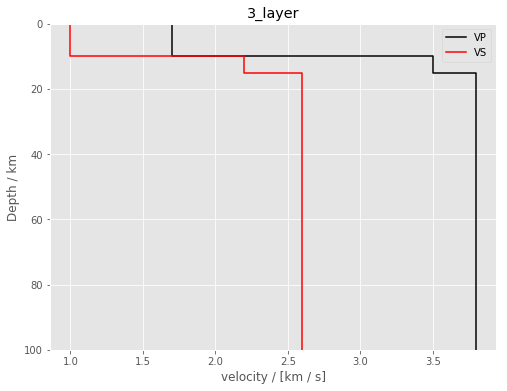

In [3]:
from pymesher.models_1D import model
m = model.read('3_layer.bm')
m.plot_vp_vs_profile(depth=True)

The model provides the discontinuities and functionality to compute element sizes according to the resolution criterion. Internally, we work with normalized coordinates, hence the need to scale.

In [4]:
print('discontinuities:', m.discontinuities * m.scale)
print('element size:   ', m.get_edgelengths(dominant_period=1., elements_per_wavelength=2) * m.scale)

discontinuities: [      0.   85000.   90000.  100000.]
element size:    [ 1300.  1100.   500.]


##### Exercise: Vary hmax_refinement, refinement_style and refinement_top_down to make the best mesh.

Note: Top down approach means minimizing number of elements at the surface at the cost of more elements at the bottom (default). If False, bottom up approach is used, that is minimizing number of elements at the bottom at the cost of more elements at the surface. Top down leads to fewer refinement. Which one is more efficient depends on the velocity model and refinement style. 

In [5]:
frequency = .1          # maximum frequency in Hz
max_x = 200000.         # Domain size in horizontal direction in m
hmax_refinement = 1.5   # critertion to avoid refinements in thin layers, need to be > 1.0,
                        # default is 1.5, smaller value = more aggressive
refinement_style = 'doubling'  # 'doubling' or 'tripling'
refinement_top_down = True     # True or False

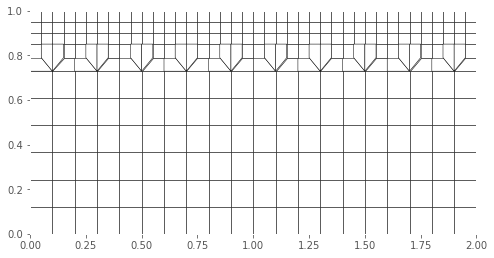

In [6]:
from pymesher.skeleton import Skeleton

horizontal_boundaries = (np.array([0]), np.array([max_x / m.scale]))
sk = Skeleton.create_cartesian_mesh(m.discontinuities,
                                    m.get_edgelengths(1./frequency),
                                    hmax_refinement=hmax_refinement,
                                    horizontal_boundaries=horizontal_boundaries,
                                    refinement_top_down=refinement_top_down,
                                    refinement_style=refinement_style)
mesh = sk.get_unstructured_mesh()
mesh.plot()

### 2) Judge the quality



#### a) Skewness
Make sure we don't have skewed elements (skewness <~ 0.75).

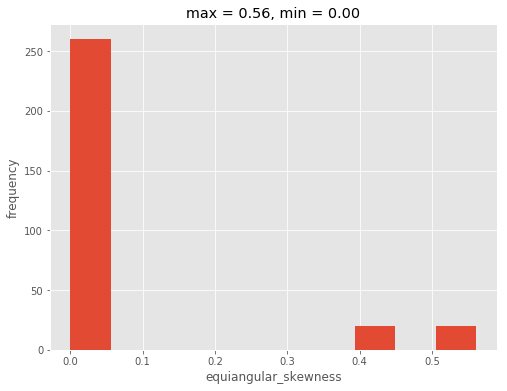

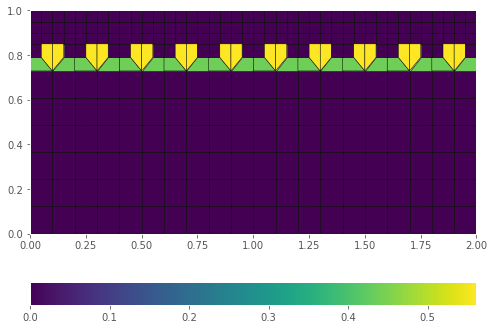

In [7]:
mesh.plot_quality('equiangular_skewness')
mesh.plot(data=mesh.compute_mesh_quality('equiangular_skewness'))

#### b) resolution criterion
make sure the elements are smaller than required by the resolution criterion (h / h_in < 1.)

1.0


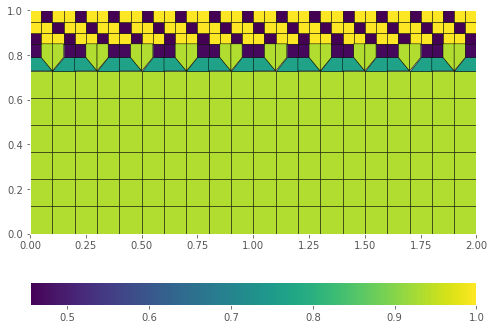

In [8]:
h = mesh._hmax() / sk.hmax  # sk.hmax stores the edgelengths as required when building the mesh with create()
print(h.max())
mesh.plot(data=h)

#### c) Simulation Cost (proportional to number of elements / time step)

In [9]:
z = mesh.get_element_centroid()[:, -1]
vp = m.get_elastic_parameter('VP', z, scaled=False)
dt, dt_elem = mesh.compute_dt(vp)  
# ignoring the courant number as this is the same for 
# all meshes and depends on the polynomial order and time integration scheme
print("%i" % mesh.nelem)
print("%.2f" % dt)
print("%.1f" % (mesh.nelem / dt))

300
1.32
228.0


plot dt over the mesh to locate the minimum:

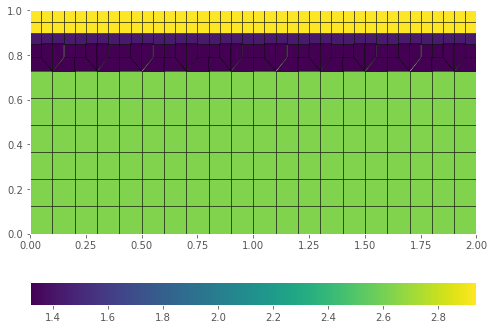

In [10]:
mesh.plot(data=dt_elem)